### ZOMATO RESTAURANT ANALSYIS AND SEGMENTATION PROJECT


##### OBJECTIVE

1. Analyzing restaurant pricing and customer satisfaction trends.
2. Performing sentiment analysis on customer reviews.
3. Segmenting the restaurants using clustering.
4. Extracting business insights for stakeholders.

### SUMMARY
This project examines the data of Zomato restaurants to assess customer satisfaction and pricing trends. After completing data cleaning and exploratory data analysis, customer reviews were analyzed to assess patterns of customer sentiment and common themes.

Restaurant-level variables such as average rating, cost, and number of reviews were engineered and scaled. KMeans clustering was used to group restaurants into significant clusters, and the number of clusters was determined using the Elbow Method. The model was assessed using the Silhouette Score.

#### IMPORTING LIBRARIES

In [30]:
# Basic data handling libraries
import pandas as pd
import numpy as np

# For  data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download stopwords once (needed for cleaning reviews)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### LOADING DATASETS

In [31]:
# Loading restaurant metadata dataset
meta_df = pd.read_csv("Zomato Restaurant names and Metadata.csv")

# Loading restaurant reviews dataset
review_df = pd.read_csv("Zomato Restaurant reviews.csv")

# Checking first few (particulary 5)rows to understand structure
meta_df.head()
review_df.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


#### CLEANING SECTION

In [32]:
# Checking  the data types of variables  and missing values
meta_df.info()
review_df.info()

# Checking  for null values
meta_df.isnull().sum()
review_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

#DATA CLEANING


In [33]:
# Removing duplicate restaurant entries WHICH ARE REPEATED MORE THAN ONCE
meta_df.drop_duplicates(inplace=True)

# Cleaning the Cost column
# Cost values also contain symbols like ₹ and text like for two
meta_df['Cost'] = meta_df['Cost'].str.replace('₹', '', regex=False)
meta_df['Cost'] = meta_df['Cost'].str.replace(',', '', regex=False)
meta_df['Cost'] = meta_df['Cost'].str.replace(' for two', '', regex=False)

# Converting cost column to numeric so that i can perform analysis
meta_df['Cost'] = pd.to_numeric(meta_df['Cost'], errors='coerce')

meta_df.head()


,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,1300,"Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,1200,"Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


#DATA CLEANIING -REVIEWS.CSV


In [34]:
# Removing the duplicated reviews
review_df.drop_duplicates(inplace=True)

# Removing the rows where review text is missing
review_df.dropna(subset=['Review'], inplace=True)

# Cleaning Rating column
# Sometimes rating contains invalid values like 'Like'
review_df = review_df[review_df['Rating'] != 'Like']
review_df = review_df[review_df['Rating'] != '-']

# Converting rating to numeric for sentiment classification
review_df['Rating'] = pd.to_numeric(review_df['Rating'], errors='coerce')

# Removing rows where rating conversion failed
review_df.dropna(subset=['Rating'], inplace=True)

review_df.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0


#### EDA(EXPLORATORY DATA ANALYSIS)

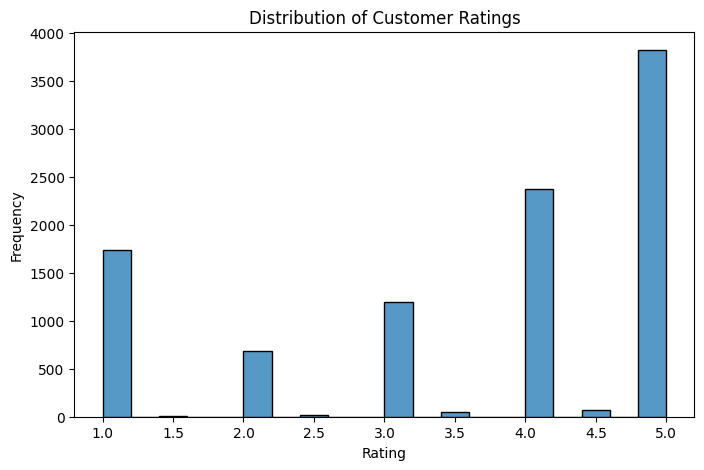

In [35]:
merged_df = pd.merge(
    meta_df,
    review_df,
    left_on='Name',
    right_on='Restaurant'
)

merged_df.head()

#Rating distribution to understand customer satisifaction trends

plt.figure(figsize=(8,5))
sns.histplot(merged_df['Rating'], bins=20)

plt.title("Distribution of Customer Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")

plt.show()

### We are using histogram because:
# 1. Ratings are continuous numerical values.
# 2. Histogram helps us understand distribution pattern.
# 3. It shows whether ratings are skewed towards high values (positive reviews).
# 4. Helps identify if majority reviews are above 4 (indicating satisfaction).

# USING HISTOGRAMS BECAUSE WE WANT TO FIND WHETHER MOST OF THE REVIEWS ARE POSITIVE OR NOT
#ARE RATINGS SKEWED OR NOT

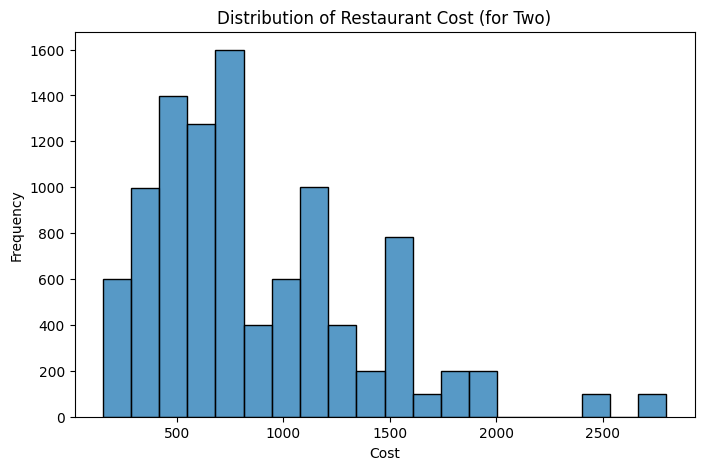

In [36]:
# Cost Distribution Analysis
# This is going to help us understand how restaurants are priced.

plt.figure(figsize=(8,5))
sns.histplot(merged_df['Cost'], bins=20)

plt.title("Distribution of Restaurant Cost (for Two)")
plt.xlabel("Cost")
plt.ylabel("Frequency")

plt.show()

# We use histogram because cost is numerical.
# This helps identify:
# - Most common price range
# - Whether restaurants are mostly budget-friendly or premium



In [37]:
# Calculating average rating per restaurant
restaurant_avg_rating = merged_df.groupby('Name')['Rating'].mean().sort_values(ascending=False)
#Top10 highest rating restros
restaurant_avg_rating.head(10)



Name
AB's - Absolute Barbecues                  4.88
B-Dubs                                     4.81
3B's - Buddies, Bar & Barbecue             4.76
Paradise                                   4.70
Flechazo                                   4.66
The Indi Grill                             4.60
Zega - Sheraton Hyderabad Hotel            4.45
Over The Moon Brew Company                 4.34
Beyond Flavours                            4.28
Cascade - Radisson Hyderabad Hitec City    4.26
Name: Rating, dtype: float64

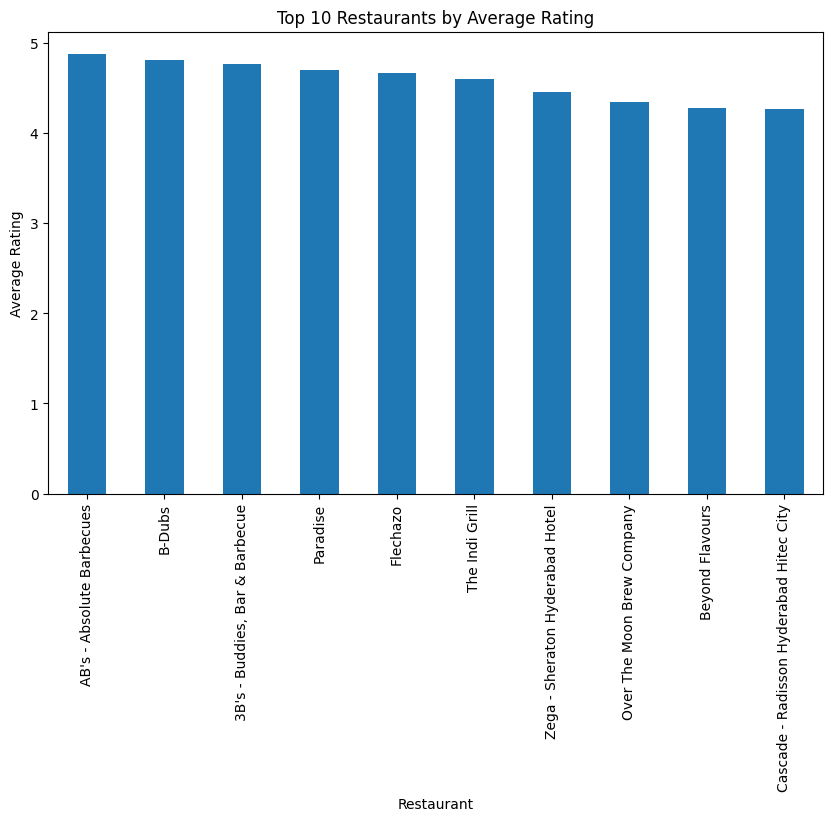

In [38]:
plt.figure(figsize=(10,6))
restaurant_avg_rating.head(10).plot(kind='bar')

plt.title("Top 10 Restaurants by Average Rating")
plt.xlabel("Restaurant")
plt.ylabel("Average Rating")

plt.show()


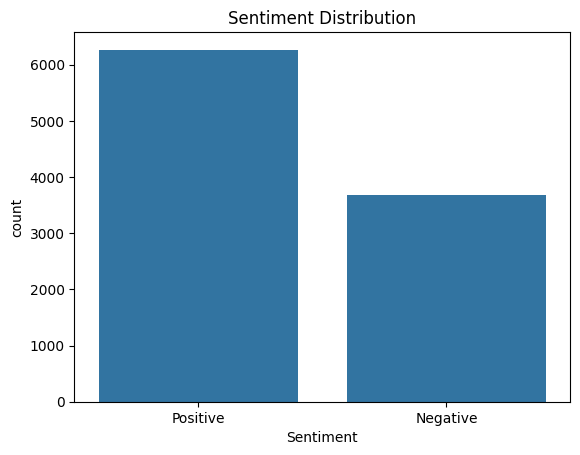

In [39]:
# Classifying sentiment based on rating

merged_df['Sentiment'] = merged_df['Rating'].apply(
    lambda x: "Positive" if x >= 4 else "Negative"
)

sns.countplot(x='Sentiment', data=merged_df)

plt.title("Sentiment Distribution")
plt.show()

# We use rating threshold method because rating directly reflects customer satisfaction.
# This is a simple but effective rule-based sentiment classification.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


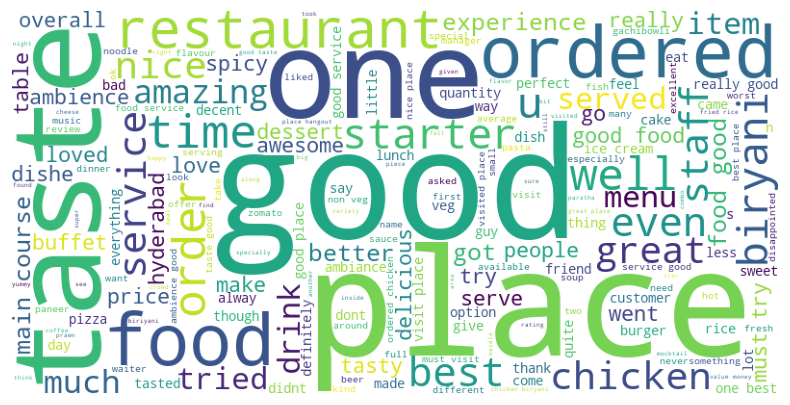

In [ ]:
# Import required libraries if not already imported
import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')

# Create stopword list
stop_words = set(stopwords.words('english'))

# Function to clean review text
def clean_text(text):
    text = str(text).lower()  # convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove common words
    return " ".join(words)

# Apply cleaning function
merged_df['cleaned_review'] = merged_df['Review'].apply(clean_text)

merged_df.head()

all_reviews = " ".join(merged_df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Word cloud helps visually identify most frequent words used by customers.Bigger the word the more it is used i mean the biigger the more frequent review given 


In [43]:
# Creating sentiment category based on rating value
# If rating >= 4 → Positive
# If rating < 4 → Negative

merged_df['Sentiment'] = merged_df['Rating'].apply(
    lambda x: "Positive" if x >= 4 else "Negative"
)

merged_df.head()


,Name,Links,Cost,Collections,Cuisines,Timings,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Sentiment,cleaned_review
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,Positive,ambience good food quite good saturday lunch c...
1,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Positive,ambience good pleasant evening service prompt ...
2,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,Positive,must try great food great ambience thnx servic...
3,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Positive,soumen das arun great guy behavior sincerety g...
4,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Positive,food goodwe ordered kodi drumsticks basket mut...


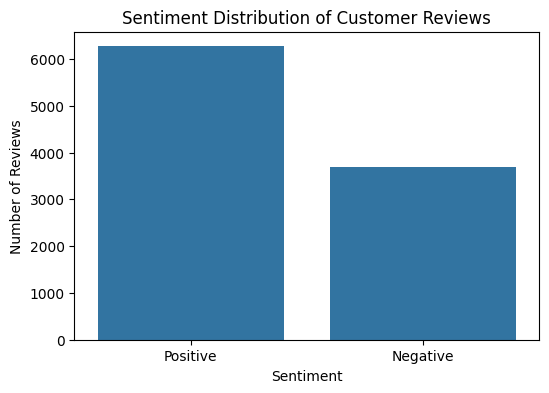

In [44]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=merged_df)

plt.title("Sentiment Distribution of Customer Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

plt.show()

# This helps us understand whether majority of reviews are positive or negative.


In [45]:
sentiment_percentage = merged_df['Sentiment'].value_counts(normalize=True) * 100
sentiment_percentage


Sentiment
Positive    62.96966
Negative    37.03034
Name: proportion, dtype: float64

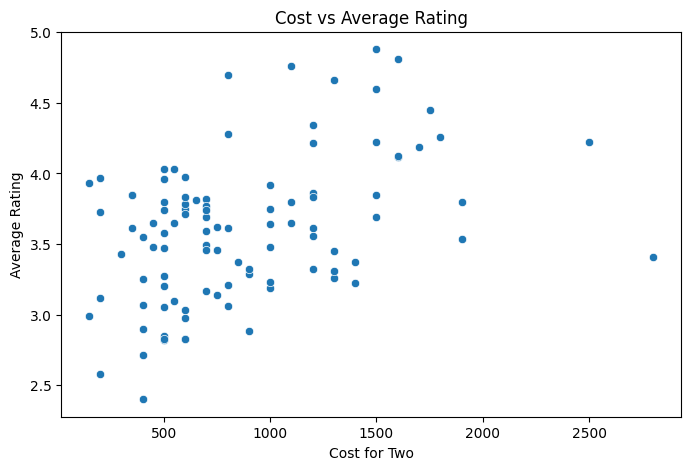

In [46]:
# Calculating average rating per restaurant
avg_data = merged_df.groupby('Name').agg({
    'Rating': 'mean',
    'Cost': 'first'
}).reset_index()

plt.figure(figsize=(8,5))
sns.scatterplot(x='Cost', y='Rating', data=avg_data)

plt.title("Cost vs Average Rating")
plt.xlabel("Cost for Two")
plt.ylabel("Average Rating")

plt.show()

# This helps analyze whether expensive restaurants receive better ratings.


#### RESULTS

##### 1.TOP PERFORMING RESTROS

##### 2.MOST REVIEWED RESTAURANTS

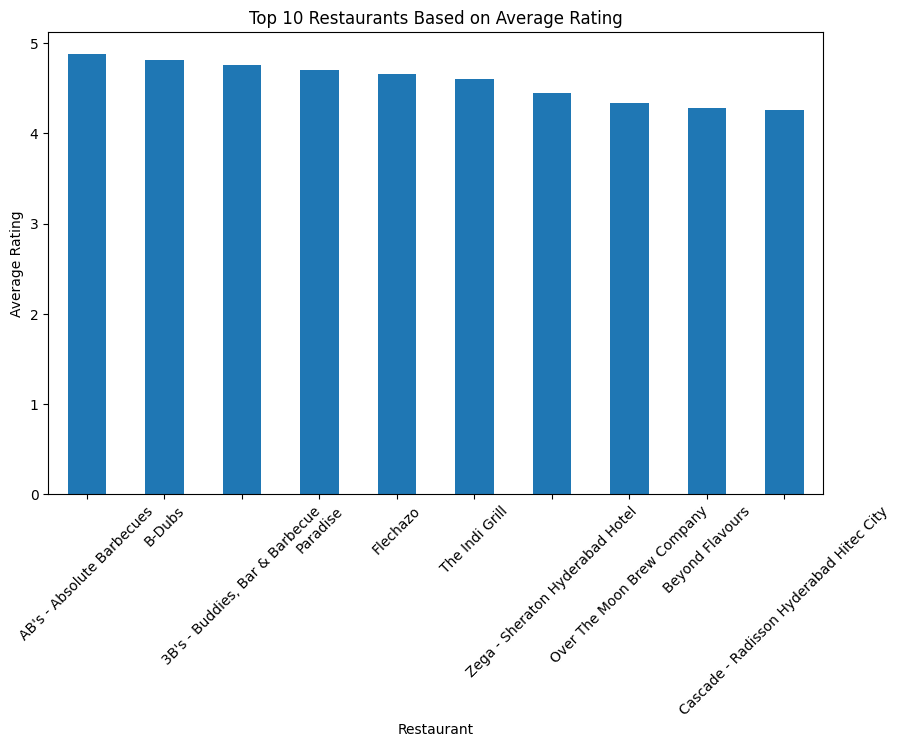

In [47]:
# Top 10 restaurants based on average rating

top_restaurants = merged_df.groupby('Name')['Rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_restaurants.plot(kind='bar')

plt.title("Top 10 Restaurants Based on Average Rating")
plt.xlabel("Restaurant")
plt.ylabel("Average Rating")

plt.xticks(rotation=45)
plt.show()

# This helps identify consistently high-performing restaurants.


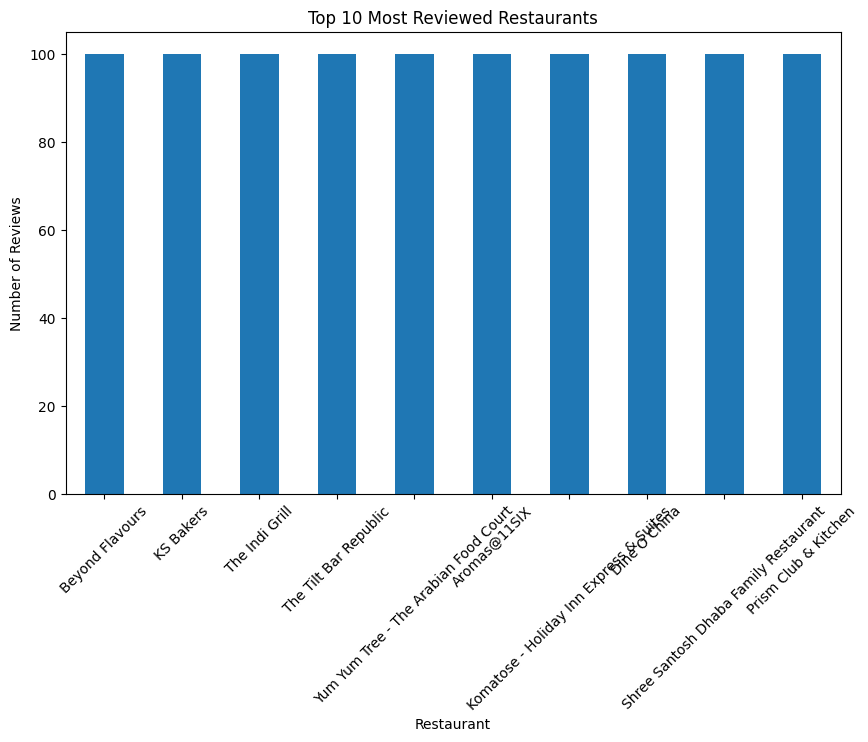

In [48]:
# Most reviewed restaurants

most_reviewed = merged_df['Name'].value_counts().head(10)

plt.figure(figsize=(10,6))
most_reviewed.plot(kind='bar')

plt.title("Top 10 Most Reviewed Restaurants")
plt.xlabel("Restaurant")
plt.ylabel("Number of Reviews")

plt.xticks(rotation=45)
plt.show()

# This shows which restaurants attracted the most customer engagement.


## Restaurant Segmentation using Clustering

In this section, we are segmenting restaurants based on cost, rating, and popularity using KMeans clustering.


In [ ]:
# Creating restaurant-level dataset for clustering

restaurant_data = merged_df.groupby('Name').agg({
    'Rating': 'mean',
    'Cost': 'first',
    'Review': 'count'
}).reset_index()

restaurant_data.rename(columns={'Review': 'Review_Count'}, inplace=True)

restaurant_data.head()




,Name,Rating,Cost,Review_Count
0,10 Downing Street,3.80,1900,100
1,13 Dhaba,3.48,450,100
2,"3B's - Buddies, Bar & Barbecue",4.76,1100,100
3,AB's - Absolute Barbecues,4.88,1500,100
4,Absolute Sizzlers,3.62,750,100


### Feature Engineering

We are creating additional features to improve clustering performance.


In [50]:
# Feature Engineering

restaurant_data['Popularity_Score'] = restaurant_data['Review_Count'] / restaurant_data['Review_Count'].max()

restaurant_data['Cost_Category'] = pd.cut(
    restaurant_data['Cost'],
    bins=3,
    labels=['Budget', 'Mid-Range', 'Premium']
)

restaurant_data.head()


,Name,Rating,Cost,Review_Count,Popularity_Score,Cost_Category
0,10 Downing Street,3.80,1900,100,1.0,Mid-Range
1,13 Dhaba,3.48,450,100,1.0,Budget
2,"3B's - Buddies, Bar & Barbecue",4.76,1100,100,1.0,Mid-Range
3,AB's - Absolute Barbecues,4.88,1500,100,1.0,Mid-Range
4,Absolute Sizzlers,3.62,750,100,1.0,Budget


### Preprocessing and Feature Scaling

Since clustering is distance-based, feature scaling is required here.


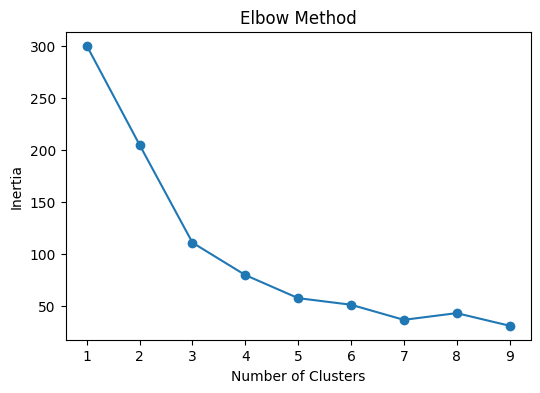

In [52]:
from sklearn.preprocessing import StandardScaler

features = restaurant_data[['Rating', 'Cost', 'Review_Count']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

from sklearn.cluster import KMeans

inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1,10), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()




In [54]:
# Applying KMeans with chosen number of clusters (example: 3)

kmeans = KMeans(n_clusters=3, random_state=42)

restaurant_data['Cluster'] = kmeans.fit_predict(scaled_features)

restaurant_data.head()


,Name,Rating,Cost,Review_Count,Popularity_Score,Cost_Category,Cluster
0,10 Downing Street,3.80,1900,100,1.0,Mid-Range,1
1,13 Dhaba,3.48,450,100,1.0,Budget,0
2,"3B's - Buddies, Bar & Barbecue",4.76,1100,100,1.0,Mid-Range,1
3,AB's - Absolute Barbecues,4.88,1500,100,1.0,Mid-Range,1
4,Absolute Sizzlers,3.62,750,100,1.0,Budget,0


### Model Evaluation

We evaluate clustering performance using Silhouette Score.


In [55]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_features, restaurant_data['Cluster'])

print("Silhouette Score:", score)


Silhouette Score: 0.4431057164434019


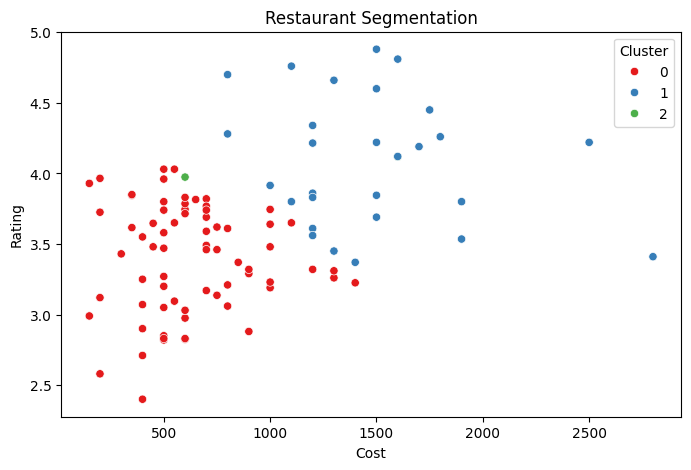

In [61]:
plt.figure(figsize=(8,5))

sns.scatterplot(
    x='Cost',
    y='Rating',
    hue='Cluster',
    data=restaurant_data,
    palette='Set1'
)

plt.title("Restaurant Segmentation")
plt.show()






In [ ]:
restaurant_data.groupby('Cluster').mean(numeric_only=True)


,Rating,Cost,Review_Count,Popularity_Score
Cluster,,,,
0,3.395963,627.857143,99.885714,0.998857
1,4.085000,1466.071429,100.000000,1.000000
2,4.045837,1100.000000,81.000000,0.810000


### Cluster Interpretation(REAL MEANING)

Cluster 0:
- Moderately average rating of restros
- Moderate cost-Not too high not too cheap
- Average review counts
→ Represents mid-range performing restaurants.

Cluster 1:
- Higher average rating among all restros
- Higher cost comparitavely
- Strong review engagement
→ Represents premium, high-performing restaurants.

Cluster 2:
- Lower review count
- Possibly lower ratings
→ Represents developing or low-engagement restaurants.
